# We align everything now!!!

assuming 20 filter, 100 all images (6 classes, 3 visualisation images each = 18 img choice)

-> we need all images here!!!

Input:
* activation maps = 2000 = 100*20
* msks (layer) = 100
* disease csv (manual) = 1
* gradcam = 100

Output:

Output for each image choice:
* gradcam + layers = 360 = 3*6*20

Output for each image choice * filter:
* activation maps + layers = 360 = 3*6*20

Output for each filter:
* CSV with image stats = 20
* Boxplot = 20
* radar = 20

Todo:
* make sure the y axis is dependent on the min and max value of all data


# SHOULD WE ONLY TAKE CORRECTLY CLASSIFIED ACTIVATION MAPS??

## imports

In [30]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
from PIL import Image

import sys
sys.path.insert(0, "helper")
sys.path.insert(0, "../helper")

# print(sys.path)

# own module
from helper.visualisation.colour import *
from helper.data.transform.octa500_resize import *



## Settings

In [31]:
# Prepare index for accessing layer data
id_minus_one = 0 # 200 - 1  # Adjust for zero-based indexing

# image 200 == mask array 199

the_dir = "examples/example_results/lightning_logs/version_14/"
the_dir = "examples/example_results/lightning_logs/first_ever_experiment_xAI/version_0"

tmp_path = os.path.join(the_dir, "final_plots")
os.makedirs(tmp_path, exist_ok=True)


# Custom order list
region = ['abyss', 'RNFL-to-IPL', 'INL-to-OPL', 'ONL+IS', 'OS', 'RPE', 'CH']
classes = ["healthy", "amd", "cnv", "dr"]

octa500_mapper = {"3" : "healthy",
                  "2" : "amd",
                  "0" : "cnv",
                  "1" : "dr"
                 }


# Helper

## get region

In [32]:
def get_region(img, mat):
    # mateos code
    
    
    # need to get 0 or 1 dependent on the image size, lets hope everything is square ...
    # mat.append(np.array([img.shape[0]]*img.shape[0]))
    
    #print("mat")
    # 6, 400, 2
    #print(mat.shape)
    #print(mat[:,0:img.shape[0],0].shape) # y axis = 30
    #print(mat[:,0:img.shape[0],1].shape) # x axis = 0

    # Example data
    b = mat[:,:,1] # np.linspace(0, 30, 50)  # 50 positions between 0 and 30 (floating points)
    values = mat[:,:,0]  # 50 corresponding floating-point values

    # Integer positions to map
    b_int = np.arange(0, img.shape[0])
    
    #print(b)
    #print(values)
    #print(b_int)
    

    # Interpolate values at integer positions
    
    interpolated_values = []
    for b_item, values_item in zip(b, values):
        ip = np.interp(b_int, b_item, values_item)
        ip = np.round(ip).astype(int)
        interpolated_values.append(ip)

    #print(interpolated_values)
    
    # no minus one, otherwise the last row is missing
    mat = np.concatenate((interpolated_values, 
                         np.array([[img.shape[0]]*img.shape[0]])),
                         axis=0)
    
    rows = mat.shape[0]

    # Create border rows for segmentation
    first_row = np.full((1, len(mat[0])), -1)  # First row filled with -1
    last_row = np.full((1, len(mat[0])), len(mat) + 3)  # Last row filled with img.shape[0] + 3

    # Add the new borders to the matrix
    mat = np.vstack((first_row, mat, last_row))
    
    #print(mat.shape)
    
    regions = []

    # Iterate over the number of segments (assumed to be 7)
    for i_layer in range(rows):
        vect = []
        matrix = np.copy(img)  # Create a copy of the original image for modification

        # Iterate over each column of the image (or row??)
        for j in range(img.shape[1]):
            # Create a mask for the current segment
            mask = (np.arange(matrix.shape[0]) <= mat[i_layer, j]) | (np.arange(matrix.shape[0]) >= mat[i_layer + 1, j])

            # Modify the rows based on the mask; set pixels outside the mask to 0
            matrix[:, j][mask] = 0
            vect.append(matrix[j,:])  # Append the modified column to vect

        # Stack the modified columns to form the segmented image for this section
        regions.append(np.column_stack(vect))

        # maybe save?? check at least when i change image data todo
        # USE THIS FOR PLOTTING THE 7 REGIONS
        #plt.imshow(vect, cmap='gray')  # 'gray' colormap for grayscale effect
        #plt.show()
    
    # Display each segmented image
    #for r in results:
    #    segmented_image = Image.fromarray(r)  # Convert the segmented array back to an image
    #    segmented_image.show()  # Display the segmented image
    
    # Return a list of each section as a NumPy array
    return regions

    

## get stats
We use texture features

* Mean Intensity
* Standard Deviation
* Entropy
* Contrast (from Gray Level Co-occurrence Matrix)
* Energy (from Gray Level Co-occurrence Matrix)
* Homogeneity (from Gray Level Co-occurrence Matrix)
* Fractal Dimension
* Texture Entropy
* Local Binary Pattern (mean or variance of the histogram)
* Histogram of Oriented Gradients (mean magnitude of gradients)

In [33]:
from scipy.stats import entropy

def get_stats(regions):
    # image stats
    
    #print(regions)
    
    stats = []
    for region in regions:
        
        # Set the 'white' value (e.g., 255)
        white_value = 255

        # Flatten the array and ignore 'white' values
        values = region[region != white_value].flatten()

        # Calculate the frequency of each unique value
        unique, counts = np.unique(values, return_counts=True)
        probabilities = counts / counts.sum()

        # Calculate entropy
        array_entropy = entropy(probabilities, base=2)  # Base 2 for bits
        
        
        # print(array_entropy)
        
        stats.append(array_entropy)
    
    return stats

## log csv

In [34]:
def log_csv(filter_id, data, label, first=True):
    
    # label_list=["amd", "cnv", "dr", "healthy"] # currently random
    
    # Define your lists
    img_id = [filter_id]*7 # i can only use the id, cause we don't need the path anymore from here
    #label = label # [label_list[label_id]]*7
    # the abyss region should be empty, due to image data I expect there to be activation which is actually unwanted ... todo: put result into paper
    region = ['abyss', 'RNFL-to-IPL', 'INL-to-OPL', 'ONL+IS', 'OS', 'RPE', 'CH'] #'IML', 'IPL', 'OPL', 'ISOS', 'RPE', 'BM', 'CH'
    stat_texture1 = data
    
    # rows = len(img) * len(region) = 1000 * 6
    
    

    # Creating a DataFrame with dummy data
    """
    data = {
        'img_id': [10, 15, 14, 20, 18, 22, 30, 28, 32, 35, 33, 34, 40, 38, 42, 45, 43, 44],
        'region': ['A', 'A', 'A', 'B', 'B', 'B', 'A', 'A', 'A', 'B', 'B', 'B', 'A', 'A', 'A', 'B', 'B', 'B'],
        'Disease label': ['Class1', 'Class1', 'Class1', 'Class1', 'Class1', 'Class1',
                    'Class2', 'Class2', 'Class2', 'Class2', 'Class2', 'Class2',
                    'Class3', 'Class3', 'Class3', 'Class3', 'Class3', 'Class3'],
        'stat_texture1': [10, 15, 14, 20, 18, 22, 30, 28, 32, 35, 33, 34, 40, 38, 42, 45, 43, 44]
    }
    """
    data = {
        'img_id': img_id,
        'region': region,
        'Disease label': label,
        'stat_texture1': stat_texture1
    }

    df = pd.DataFrame(data)
    # df.to_csv("output.csv", index=False)  # Saving to CSV

    # Save DataFrame to CSV
    
    if first: # create
        df.to_csv(os.path.join(tmp_path, f'filter_{filter_id}.csv'), index=False)
    else: # append
        df.to_csv(os.path.join(tmp_path, f'filter_{filter_id}.csv'), mode='a', index=False, header=False)
    
    
    pass


## boxplot

In [35]:
def plot_boxplot(filter_id):
    
    #print(sns.color_palette("Paired"))

    #pal = sns.color_palette("Paired")
    #pal.pop(4)
    #pal.pop(4)
    #pal.insert(0, pal[6]) 
    #pal.insert(1, pal[8])     
    

    # Read the DataFrame from CSV
    df = pd.read_csv(os.path.join(tmp_path, f'filter_{filter_id}.csv'))

    # first sort by concept, then sort by class
    
    # Convert the 'Class' column to a categorical type with your custom order
    df['Disease label'] = pd.Categorical(df['Disease label'], categories=classes, ordered=True)
    df['region'] = pd.Categorical(df['region'], categories=region, ordered=True)
    # Sort the DataFrame by the 'Class' column with the custom order
    df = df.sort_values(by=['Disease label', 'region']).reset_index(drop=True)
    
    # filter_id = ("filter_12_0_3.csv".split("_", 1)[1]).split(".")[0]

    color_mapping = dict(zip(classes, normal_amd_cnv_dr.colors))
    sns.set_theme(style="ticks")
    
    # Create a boxplot with hue
    plt.figure(figsize=(14, 7))
    # or boxplot ...
    #sns.catplot(x='Layer', y='Percentage', hue='Disease', data=df, kind="violin", bw_adjust=.5, cut=0, height=3, aspect=6)
    sns.boxplot(x='region', y='stat_texture1', hue='Disease label', data=df, palette=color_mapping)

    sns.despine(offset=10, trim=True)

    # Set y-axis limits and labels
    #plt.ylim(0, 100)
    plt.ylabel('Texture')
    plt.xlabel('Retinal regions (combination of layers and membranes) and choroid')

    # Display the legend
    #plt.legend(title='Disease', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Display the plot
    plt.title(f'Boxplot of activations in filter {filter_id} by region, texture and disease')
    plt.savefig(os.path.join(tmp_path, f'filter_{filter_id}.png'))
    
    # save radar information
    # no, we just need the variance
    # 0 if the std is too high = not significant (maybe we can do an analysis of insignificance?
    # like get the significant values?
    # could do random forest for feature importance?
    # value 
    # stats*layer are used to predict something??
    
    # list of 7 regions
    #median = np.median(df)
    #std_dev = np.std(df)
    
    df_mean_and_std = df.groupby(['Disease label', 'region'])['stat_texture1'].agg(['median', 'std']).reset_index()

    df_mean_and_std.to_csv(os.path.join(tmp_path, f'mean_and_std_{filter_id}.csv'), index=False)
    
    return df_mean_and_std


## radar

In [36]:
def plot_radar(filter_id, df_mean_and_std):
    # we need to normalise between 0 and 1 - but globally ?!
    
    plt.savefig(os.path.join(tmp_path, f'radar_{filter_id}.png'))
    pass

# main

C:\Users\Prinzessin\AppData\Local\Temp\ipykernel_27564\1882726687.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(14, 7))


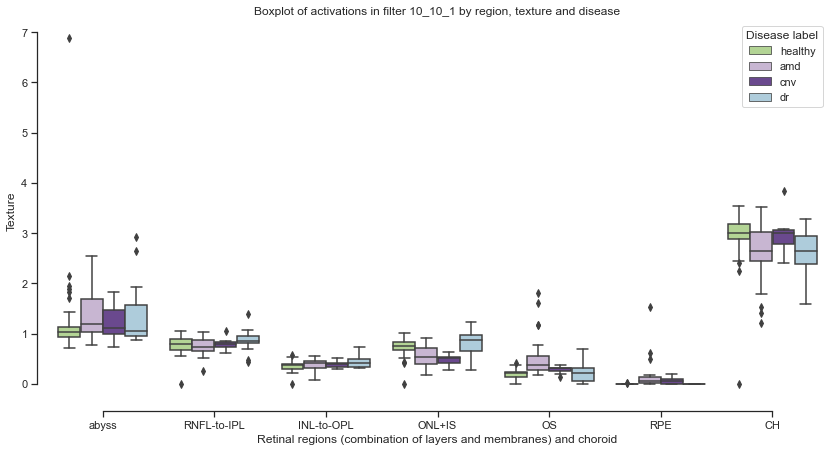

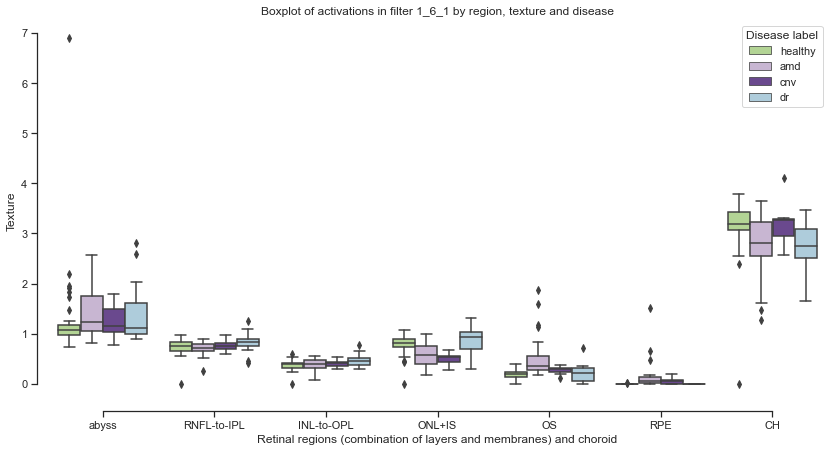

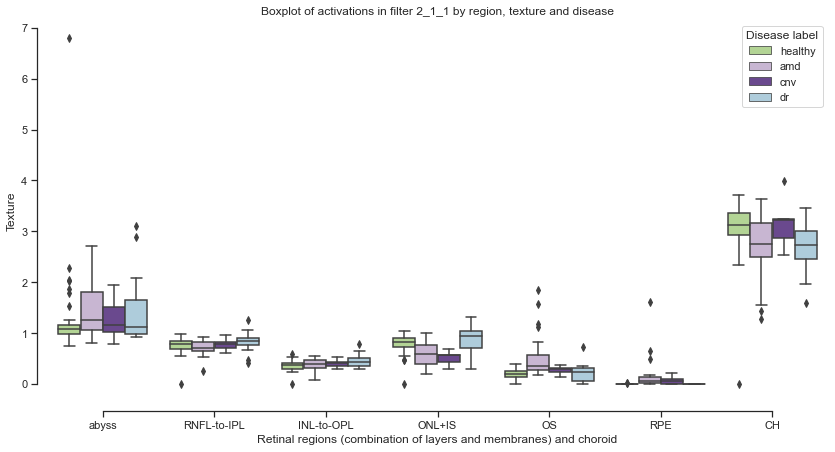

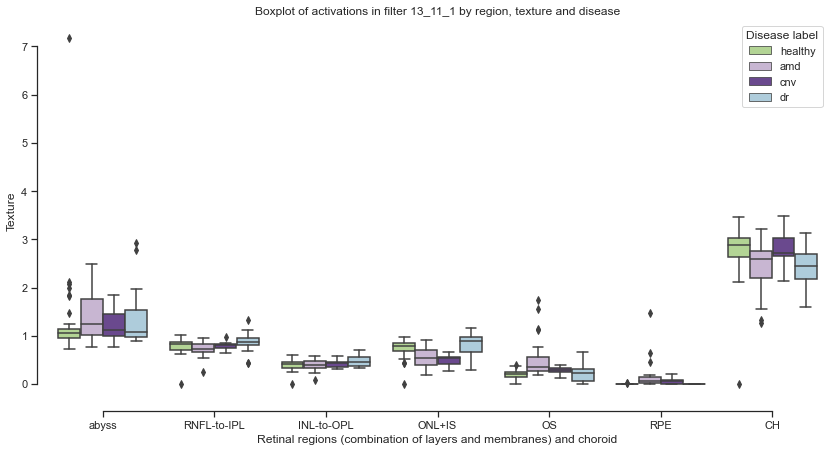

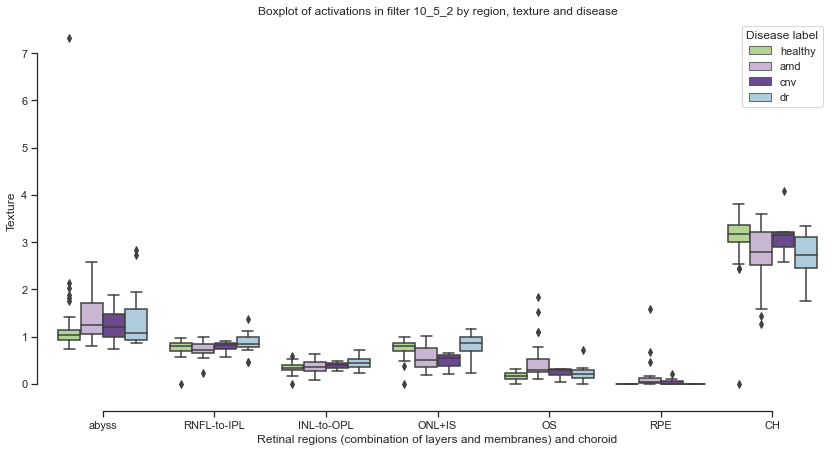

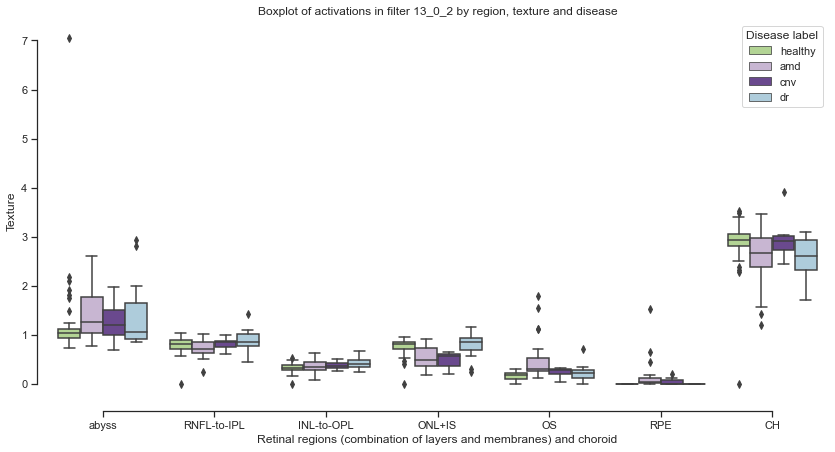

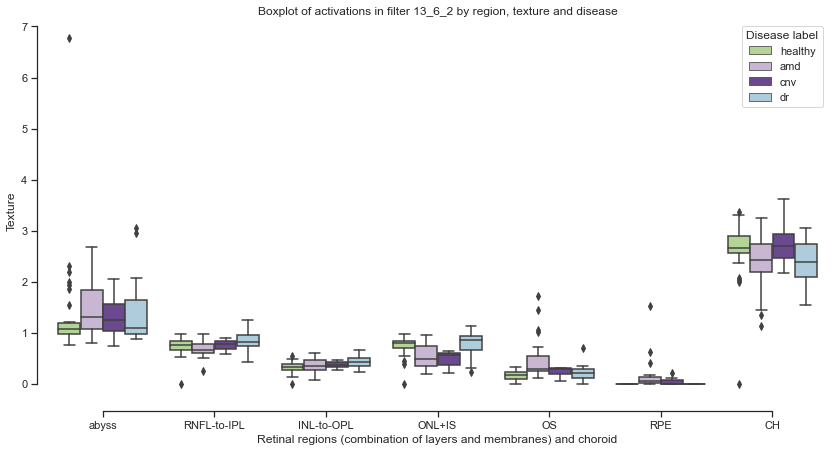

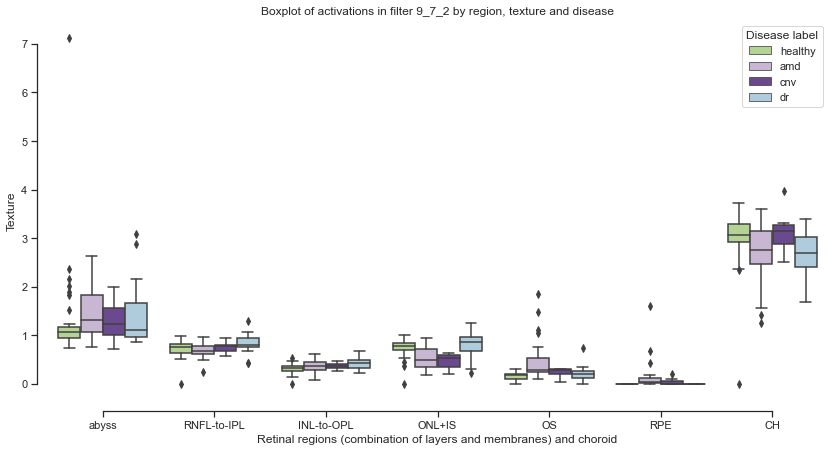

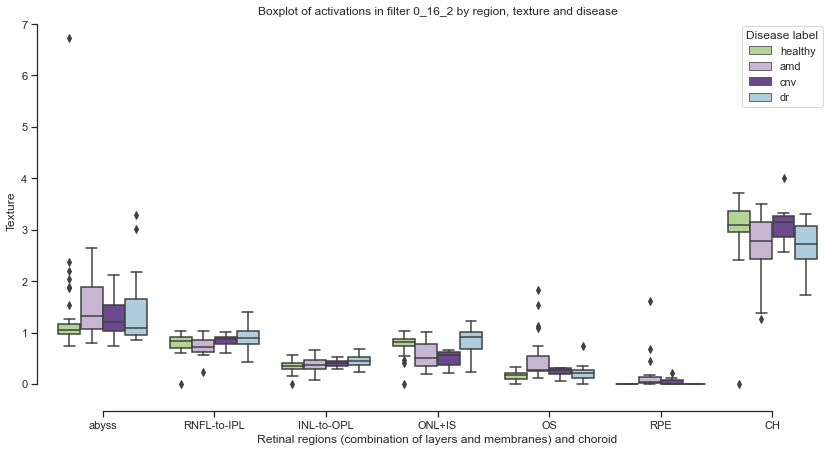

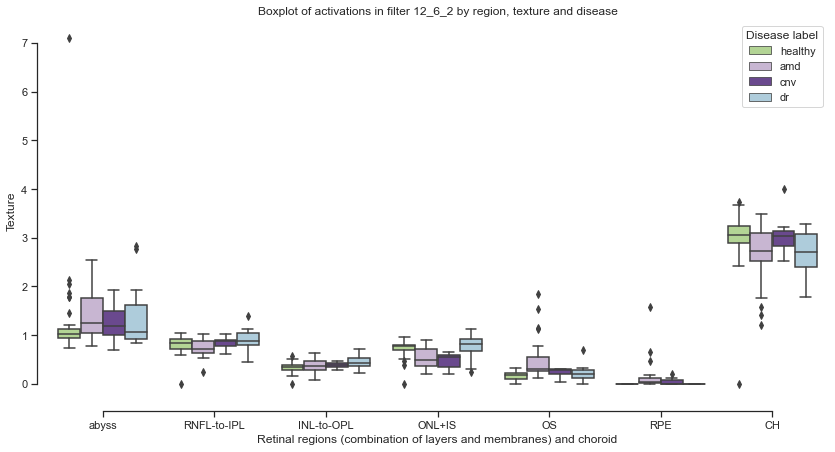

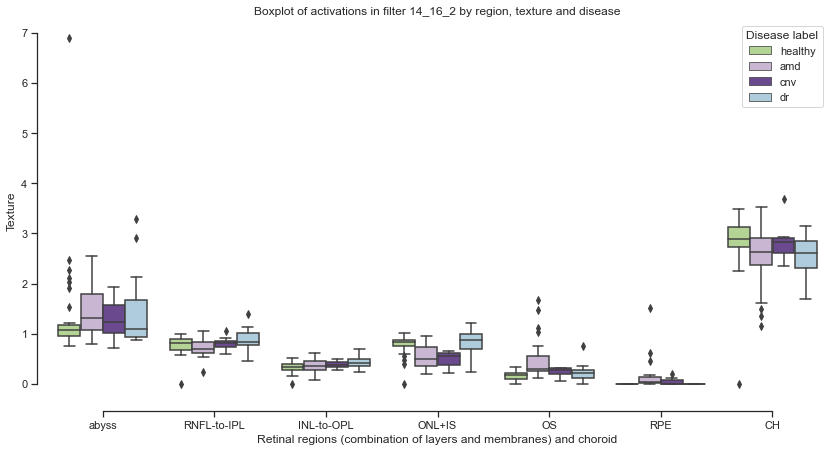

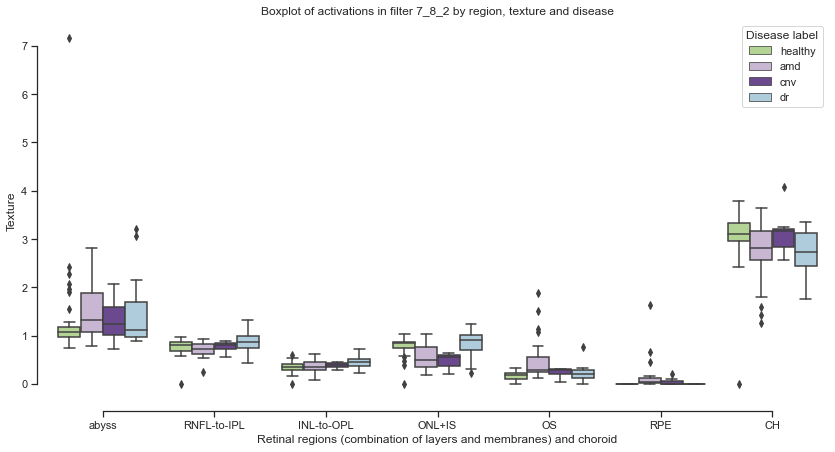

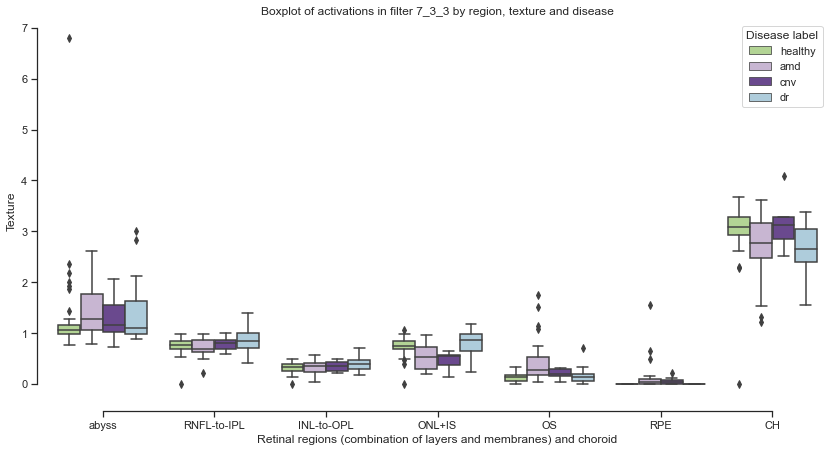

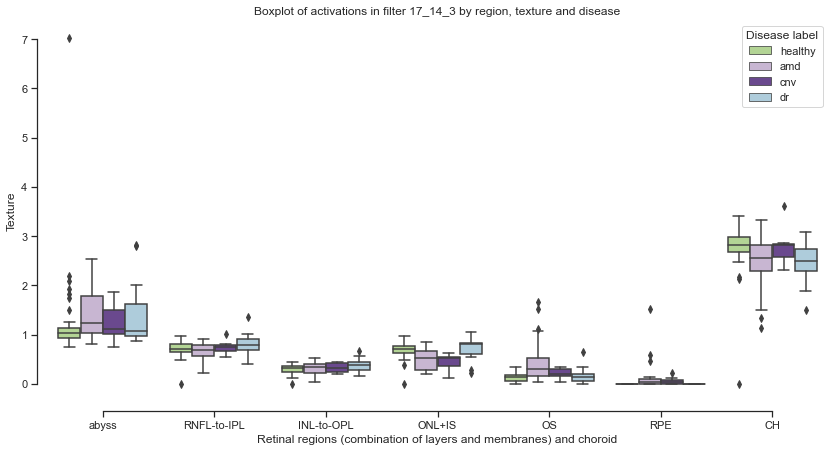

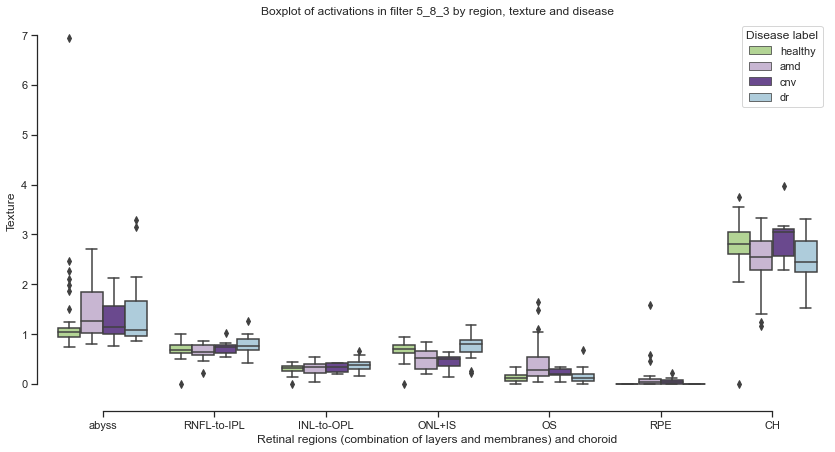

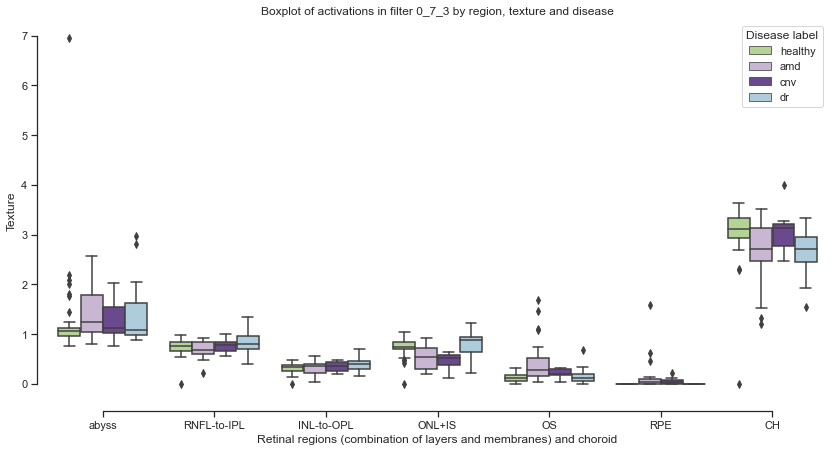

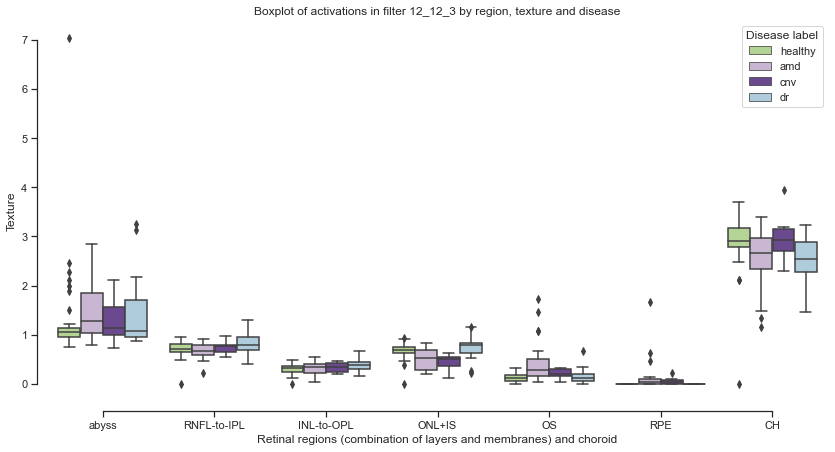

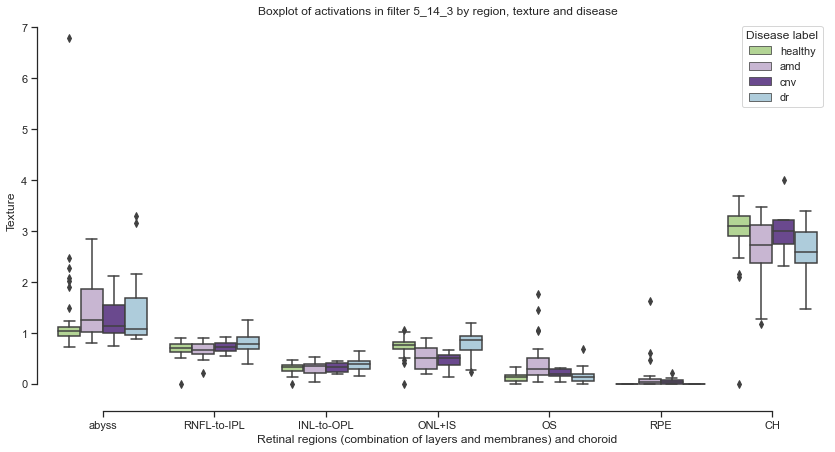

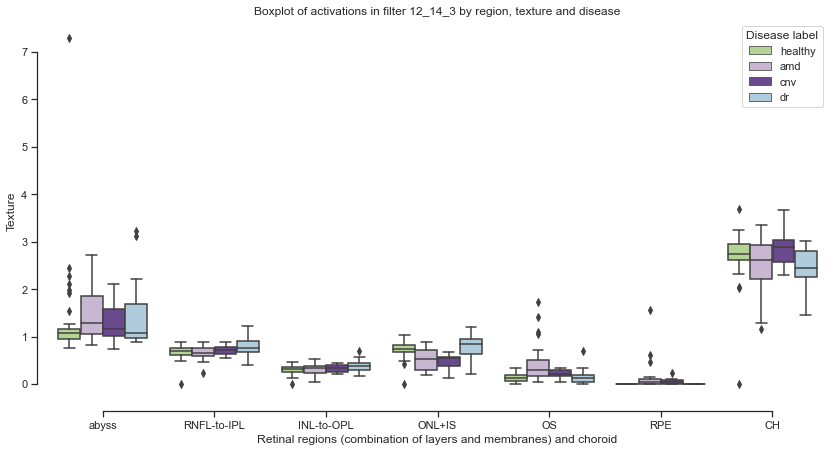

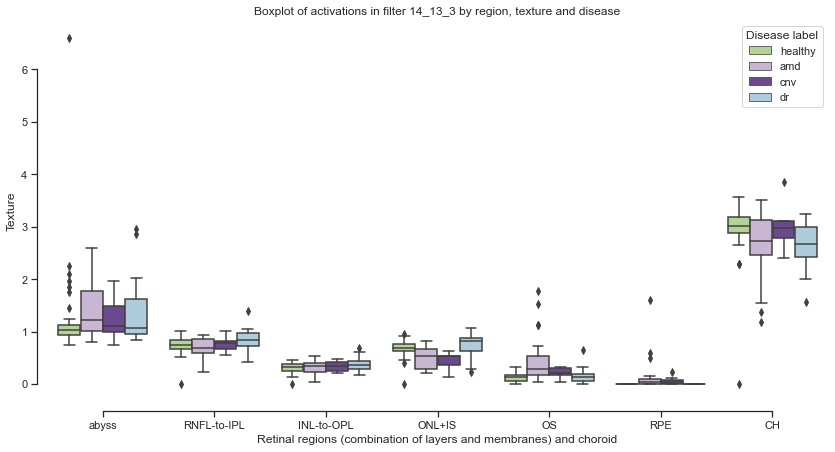

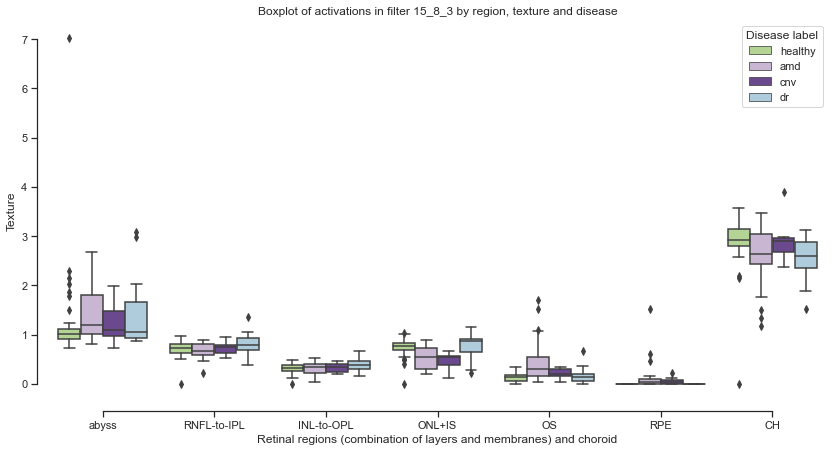

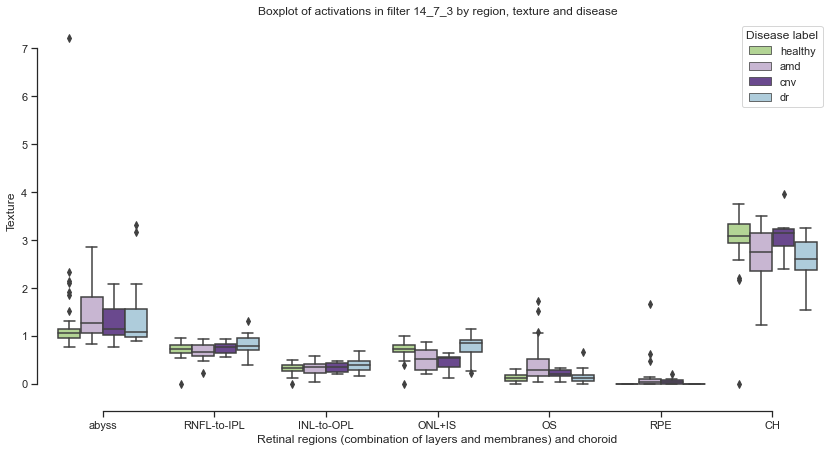

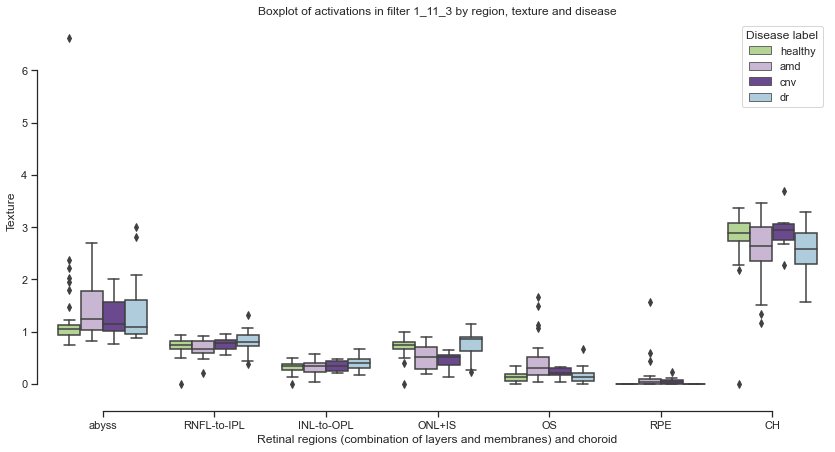

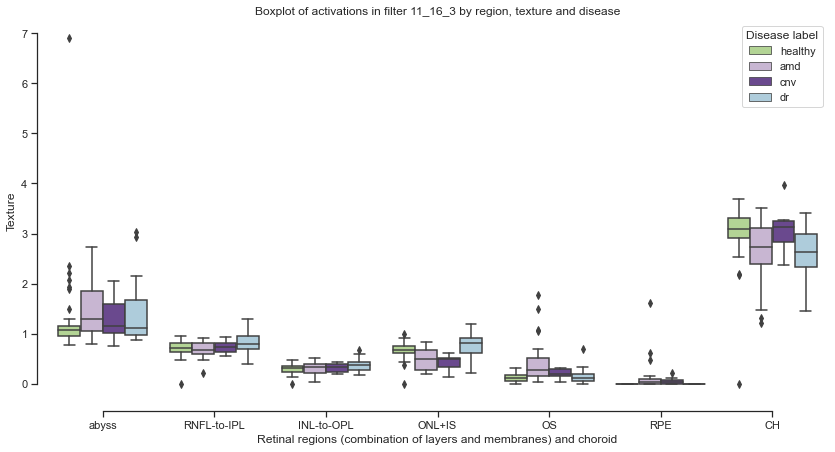

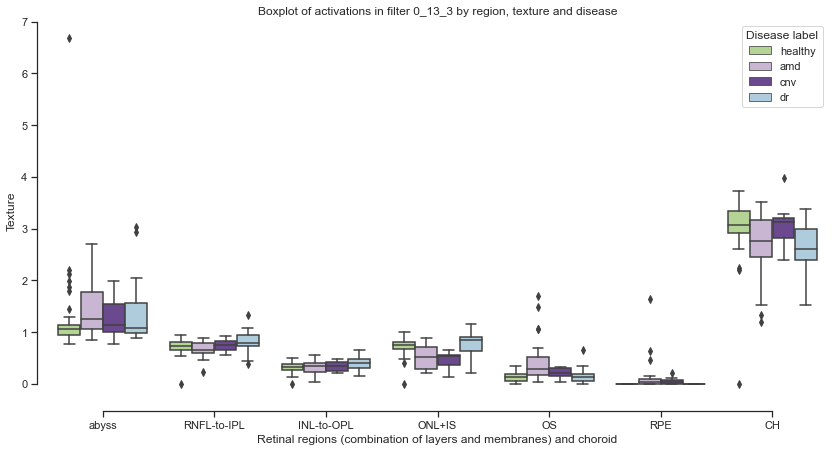

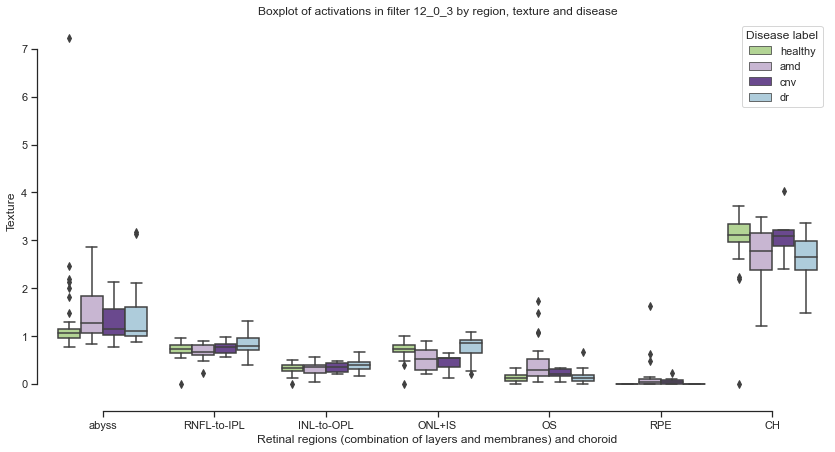

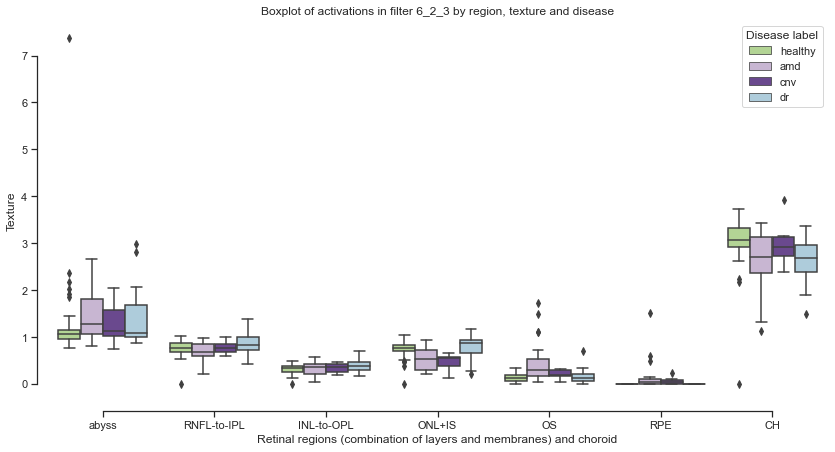

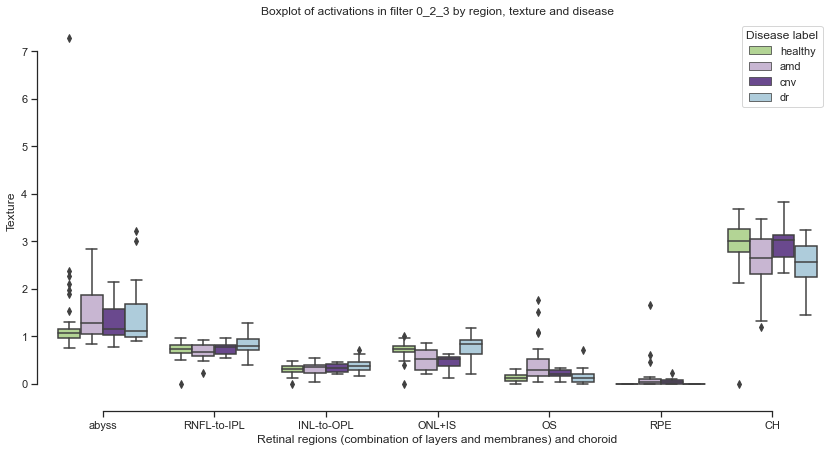

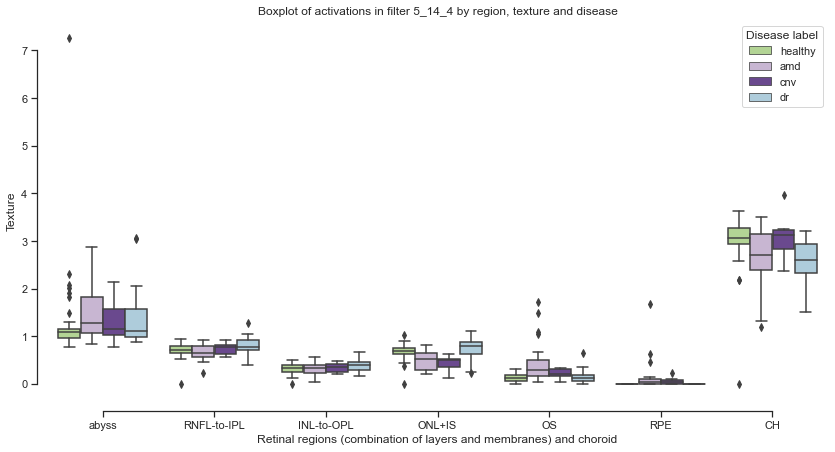

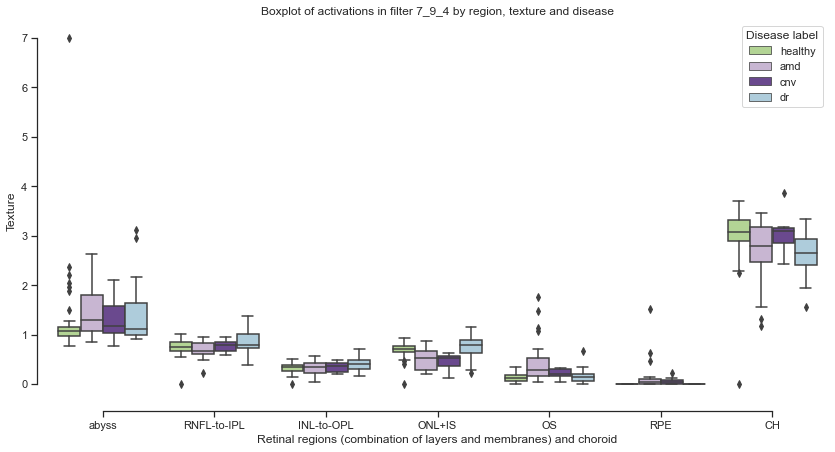

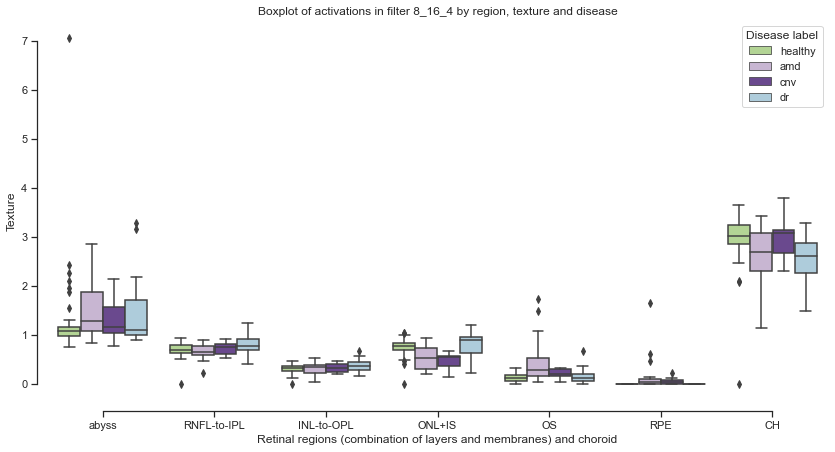

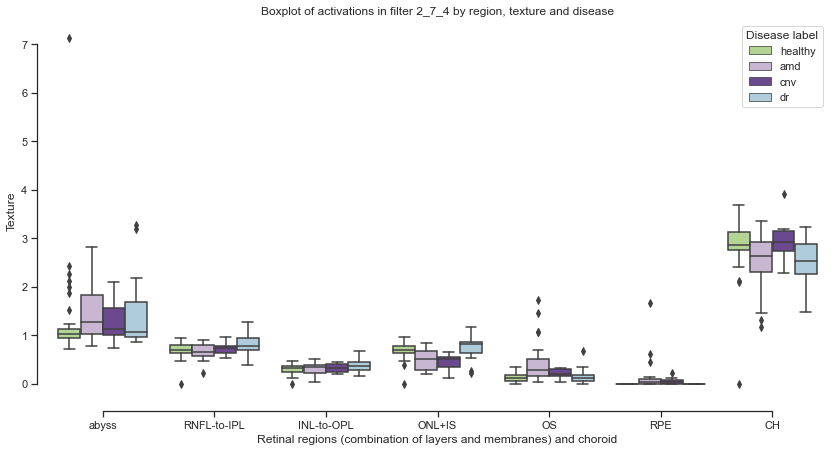

In [37]:
df = pd.read_csv(os.path.join(the_dir, "all_filters.csv"))
filter_id_list = df["filter"]

import glob
from skimage import io
import scipy.io

## Load the .mat file
#mat = scipy.io.loadmat('examples/example_data/octa500/msks_6x6/10001.mat')

    # Load a JPEG image
    #image_path = 'picture.jpeg'
    #image = Image.open(image_path)
    #img = np.array(image)

    # Display the image
    #image.show()

    
def get_and_transform_mask(img_id=None, size=26):
    
    # scipy.io.loadmat('10001.mat')
    
    # mat_size = f_path.split("_size")[1].split("_",1)[0]
    
    mat_path = glob.glob(the_dir + f"/mat_transformed_choice/*_id{img_id}_size{size}*.mat")[0]
    
    mat = scipy.io.loadmat(mat_path) # os.path.join(the_dir, "mat_transformed_choice/mat_id10001_0_0_0_mo0_gt3.mat"))
    
    #print("entry")
    #print(mat)
    
    if False:
        dummy_size = size
        dummy_mask = []
        dummy_mask.append(np.random.randint(5, 8, dummy_size).tolist())
        dummy_mask.append(np.random.randint(8, 11, dummy_size).tolist())
        dummy_mask.append(np.random.randint(12, 14, dummy_size).tolist())
        dummy_mask.append(np.random.randint(15, 16, dummy_size).tolist())
        dummy_mask.append(np.random.randint(17, 18, dummy_size).tolist())
        dummy_mask.append(np.random.randint(18, dummy_size-2, dummy_size).tolist())
        dummy_mask = np.transpose( np.array([dummy_mask]), (1, 0, 2))

    
    #print(dummy_mask)
    """
    dummy_mat = {'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Fri May 06 15:17:37 2022',
         '__version__': '1.0',
         '__globals__': [],
         'Layer': dummy_mask
                }
    
    return dummy_mat"""
    
    gt = mat_path.split("_gt")[1].split(".",1)[0]
    
    return mat, gt


for f_id in filter_id_list:
    #print(f_id.split("_",1)[1])
    # get activation maps from this filter
    f_position = f_id.split("_",1)[1]
    file_paths = glob.glob(the_dir + f"/activation_maps/*_{f_position}*.png")
    first = True
    for f_path in file_paths:
        
        #print(f_path)
        
        #print(f_path.split("_id")[1].split("_",1)[0])
        
        img_id = f_path.split("_id")[1].split("_",1)[0]
        
        # open file
        img = io.imread(f_path)
        msk, gt = get_and_transform_mask(img_id=img_id, size=img.shape[0]) # not sure whether 0 or 1, but it's a square so don't care :b
        
        regions = get_region(img, msk["Layer"]) # id_minus_one
        
        #print(f_path)
        # octa500_mapper
        
        disease = octa500_mapper[gt]

        stats = get_stats(regions) # 7 regions for 6 boundaries + max img height.
        
        # filter_id, data, first=True
        log_csv(filter_id=f_position, # os.path.basename(f_path).split(".")[0].split("_id")[1].split("_",1)[1], 
                data=stats, 
                label=disease, # todo between 0 and 4 - we need to make sure the order is correct
                first=first)
        first = False
        
        
        
        # get mask by _id*N*_
        # get region
        
        # get stats of region
        

    # for each filter we need:
    
    df_mean_and_std = plot_boxplot(f_position)
    # plot_radar(df_mean_and_std) -> in another file
    
    # break
    

# nonsense

In [ ]:
img_id = 10001
glob.glob(the_dir + f"/mat_transformed_choice/*{img_id}*.mat")

In [ ]:
# classes = ["healthy", "amd", "cnv", "dr"]
color_mapping = dict(zip(classes, normal_amd_cnv_dr.colors))
    
    
print(color_mapping)


In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Set the theme
sns.set_theme(style="whitegrid")

# Example data
data = pd.DataFrame({
    'Class': ['A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C'],
    'Value': [1, 3, 2, 4, 2, 5, 6, 4, 7]
})

# Define unique classes and create a color palette for them
classes = data['Class'].unique()
colors = sns.color_palette("Set2", len(classes))  # Change "Set2" to any palette you like

# Create a dictionary mapping each class to a specific color
color_mapping = dict(zip(classes, colors))

print(color_mapping)

# Plot using Seaborn's boxplot, passing in the custom color palette
plt.figure(figsize=(8, 6))
sns.boxplot(x='Class', y='Value', data=data, palette=color_mapping)

# Show the plot
plt.show()

In [ ]:
#np.array([img.shape[0]]*img.shape[0])

In [13]:
#msk["Layer"][:, id_minus_one].shape

In [14]:
#tmp_msk2 = np.array([[img.shape[0]-1]*img.shape[0]])


In [15]:
#tmp_msk2.shape

In [16]:
#tmp_msk = msk["Layer"][:, id_minus_one]

In [17]:
#tmp_msk.shape

In [18]:
#mat = np.concatenate((tmp_msk, tmp_msk2), axis=0)
#mat.shape

In [19]:
img.shape

(22, 22, 4)

In [20]:
np.array([10]*10)

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

In [21]:
mat["Layer"].shape

NameError: name 'mat' is not defined

In [ ]:
mat["Layer"][:, id_minus_one:5].shape

In [ ]:
dummy_mask.shape

In [ ]:
img.shape

In [ ]:
filters x

In [ ]:
for i in range(18): # -> i need all masks from octa 500 not just 3 per class
    # open msk_choice 
    pass


    for i in range(360/18): #-> i need all masks from octa 500 not just 3 per class
        # open activation_maps 
        # save acctivation_maps_with_msk
        pass


    for i in range(18/18): # we can remove the loop i guess
        # open gradcam
        # save gradcam_with_msk
        pass

# open disease csv

In [ ]:
log_csv()

plot_boxplot()

In [ ]:
# save csv with image stats
for img in range(360):
    # create dataframe
    for layer in range(7): # 7 layers (6 boundaries) - but the uppermost is ignored so ... hmmm, also ignore lower 3 px row for mnist
        # get image stats (only one will be used finally)
        # new line in dataframe
        # class, img_name, layer (region), stats
    # save csv

In [ ]:
# save boxplots
for file in range(20):
    # open csv
    # we only use one image stat for now!!
    # create boxplot
    # save

In [ ]:
# save radar

for file in range(20):
    # idk align boxplot somehow with the disease_manual.csv
    # save radar

In [ ]:
import numpy as np

# Example data
b = np.linspace(0, 30, 50)  # 50 positions between 0 and 30 (floating points)
values = np.random.random(50)  # 50 corresponding floating-point values

# Integer positions to map
b_int = np.arange(0, 31)

# Interpolate values at integer positions
interpolated_values = np.round(np.interp(b_int, b, values)).astype(int)

print(interpolated_values)